# Classification of Disaster Tweets

Twitter has become a useful tool for detecting and monitoring major events such as disasters. The goal of this study is to develop a model that can detect tweets that are describing a disaster that had taken place. A naive approach to solving this problem might be to simply scan the tweets for keywords indicative of a disaster (e.g. fire, ablaze, disaster, crash). However, this method would fail to take into account the context of those words (e.g. My hair is a disaster today!). Recurrent neural networks should take into account the contextual use of a word by considering the word's place in the tweet. Therefore, this approach is ideal in this study.

[Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data) provides a dataset, consisting of 10,000 labeled english language tweets. Please visit the link to obtain the dataset analyzed in this study. Twitter typically limits how many characters of text a user may enter into a post. This should give us some insight into how large the encoding feature space should be.

## Exploratory Data Analysis


In [ ]:
!pip install ktrain

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import ktrain

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("drive/MyDrive/nlp-getting-started/train.csv")
data.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


In [5]:
tweets = data[['text', 'target']]
tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


The raw dataset contains columns that may not be useful in the data analysis and contain a lot of NA values (i.e. id, keyword, location). These columns should therefore be dropped.

In [28]:
word_mx = 0
char_mx = 0

word_mn = 1e10
char_mn = 1e10
for (i, row) in tweets.iterrows():
  txt = row['text']
  if len(txt) > char_mx:
    char_mx = len(txt)

  if len(txt) < char_mn:
    char_mn = len(txt)

  if len(txt.split(" ")) > word_mx:
    word_mx = len(txt.split(" "))

  if len(txt.split(" ")) < word_mn:
    word_mn = len(txt.split(" "))
print("Longest character sequence {}. Longest word sequence {}".format(char_mx, word_mx))
print("Shortest character sequence {}. Shortest word sequence {}".format(char_mn, word_mn))

Longest character sequence 157. Longest word sequence 54
Shortest character sequence 7. Shortest word sequence 1


The longest tweet contains 69 words. This will be useful later when defining the size of the encoding feature space. 

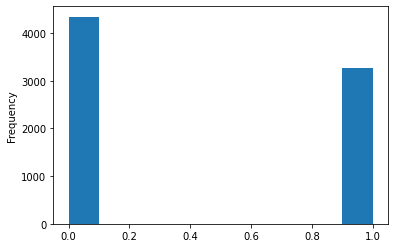

In [8]:
tweets['target'].plot.hist()

The distribution of the target variable (disaster, not disaster) is roughly balanced. Therefore, the accuracy score should be a reasonable measure of model performance.

In [9]:
tweets.isna().sum()

id        0
text      0
target    0
dtype: int64

There does not appear to be any missing values in the dataset.

### Data Transformation

Now that the dataset has been cleaned, the next step is to transform the text into a format that deep learning models can more easily work with. To do this, all the unique words in the training set can be indexed (i.e. assigned an identifying number).

In [88]:
#Split into a training set and a validation set.
train, val = train_test_split(tweets, test_size=0.1, random_state=123)
print("Train length : {}, Validation length: {}".format(len(train), len(val)))

Train length : 6851, Validation length: 762


In [89]:
#convert words into numbers
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=64)
text_ds = tf.data.Dataset.from_tensor_slices(train['text']).batch(128)
vectorizer.adapt(text_ds)

The vectorizer has standardized the text data by removing punctuation marks. In addition, all the text has been converted to lowercase. This is ideal because these text features are typically unecessary and could hinder model performance. For instance "#fire" may not be a recognized word in text embedders and valuable information may  be lost by not removing that hashtag symbol.

In [93]:
#observe how the text has been standardized
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
vocab = np.array(voc)
for (i, row) in tweets.iterrows():
  txt = row['text']
  print(txt)
  print(" ".join(vocab[vectorizer(txt)]))
  print("\n")
  if i > 5:
    break

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
our deeds are the reason of this earthquake may allah forgive us all                                                   


Forest fire near La Ronge Sask. Canada
forest fire near la ronge sask canada                                                         


All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected                                          


13,000 people receive #wildfires evacuation orders in California 
13000 people receive wildfires evacuation orders in california                                                        


Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
just got sent this photo from [UNK] alaska as smoke from wildfires [UNK] into a school 

### Visualizing the Contents of Disaster Tweets

In [43]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS 

#concatentate text associate with different values of the target variable
disasterTxt = ""
for (i, row) in tweets[tweets['target'] == 1].iterrows():
  txt = " ".join(vocab[vectorizer(row['text'])])
  disasterTxt = disasterTxt + txt + " "
  
okTxt = ""
for (i, row) in tweets[tweets['target'] == 0].iterrows():
  txt = " ".join(vocab[vectorizer(row['text'])])
  okTxt = okTxt + txt + " "

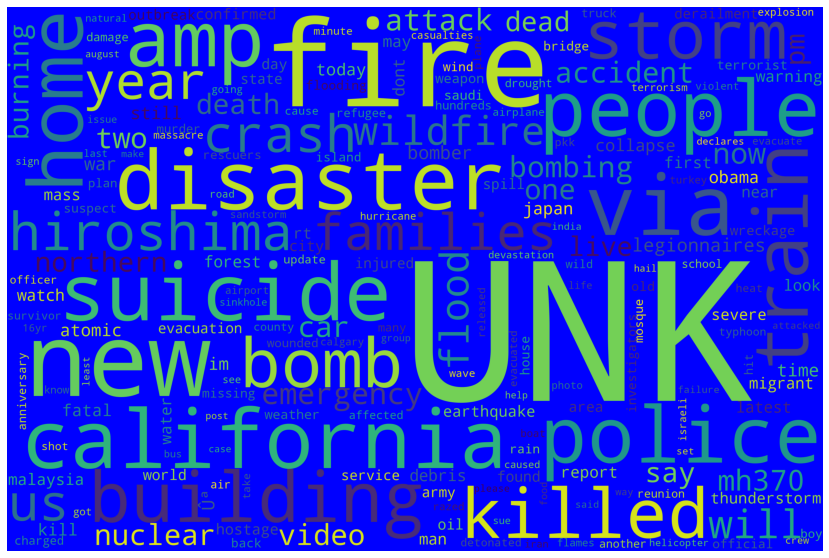

In [45]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(disasterTxt)
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

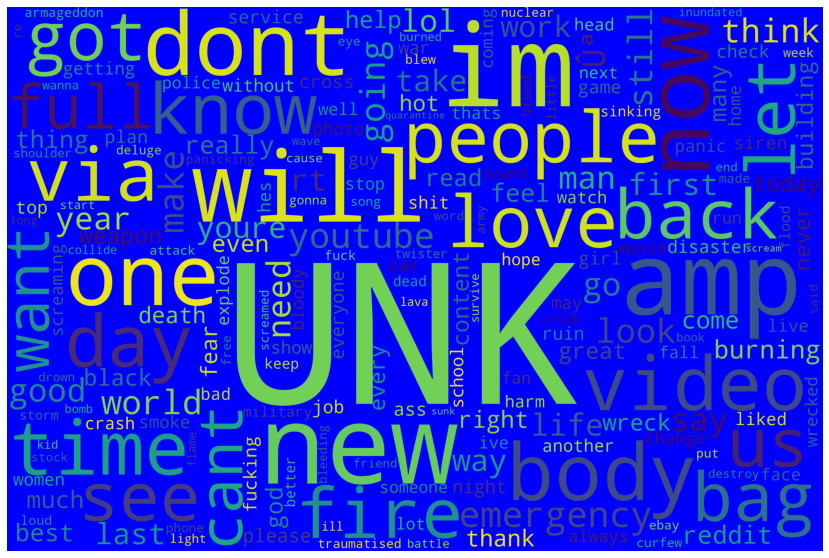

In [44]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(okTxt)
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

Based on these WordCloud plots, disaster tweets contain a higher frequency of keywords describing disasters. However, the non-disaster tweets contain a lot of disaster keywords (e.g. fire, emergency, burning, crash, smoke). Therefore, word context should be taken into account in order to produce accurate classifications. 

### Plan of Analysis

Based on the exploratory data analysis, a model should be able to classify tweets based on keywords used in the right context. This can be accomplished with a bi-directional recurrent neural network. Since the data is roughly balanced, the accuracy score is a reasonable method of quantifying the performance of models trained on these data.

## Model Architecture

Discussed in this section are two approaches for building a text classification model. The first approach is to build an RNN model from scratch, using third-party word embedding software to further reduce the size of the feature space of words.

The second approach involves leveraging a powerful, pre-trained model for the goals of this study.

In [ ]:
#download glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

At this point in the study, words have been converted into integers from 0 to 19999. Such a large space of possible words can make model construction difficult and may result in lower predictive performance.

One solution to this problem is the addition of an embedding layer. This layer reduces the space of unique words down significantly. In this case, the reduction is from 20000 to only 300. This is accomplished by assigning words with a similar meaning to the same vector representation.

Global Vectors (GloVe) is the embedding method used in this study. GloVe is unique in that it takes into account a word's context to assess its meaning. This [article](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010) explains this concept well.

In [91]:
embedding_dim = 300
path_to_glove_file = 'glove.6B.{}d.txt'.format(embedding_dim)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [94]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11129 words (8871 misses)


In [95]:
print(embedding_matrix.shape)
print(train.shape)
print(embedding_dim)

(20002, 300)
(6851, 2)
300


### Recurrent Neural Network Model
The following model takes an input of integer tokenized text, shrinks the space of unique words using a GloVe embedding, passes activations to bi-directional layers, and then processes those activations in two dense layers to make a classification. 

NLP models typically benefit from bi-directional word processing. It is usually necessary to determine the contextual meaning of a word by using information about both previous and subsequent words in the sentence.

In [96]:

#convert big feature space into small space
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)
int_sequences_input = keras.Input(shape=(64,), dtype="int64")
rnn_model = tf.keras.models.Sequential()
rnn_model.add(int_sequences_input)
rnn_model.add(embedding_layer)

#add dropout to reduce overfitting
rnn_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout = 0.5)))
rnn_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.25, return_sequences=True)))
rnn_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.1, return_sequences=True)))
rnn_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout = 0.05)))
rnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 300)           6000600   
                                                                 
 bidirectional (Bidirectiona  (None, 64, 256)          439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 64)           41216     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               10368     
 nal)                                                   

In [97]:
x_train = vectorizer(np.array([[s] for s in train['text']])).numpy()
x_val = vectorizer(np.array([[s] for s in val['text']])).numpy()

y_train = np.array(train['target'])
y_val = np.array(val['target'])

### Pre-trained BERT Model

Bidirectional Encoder Representations (BERT) is a popular natural language processing model developed by Google and pretrained on a corpus of Wikipedia articles and books. This model can be fine-tuned to classify disaster tweets. This type of model can easily be implemented with the ktrain package. A hyperparameter of interest is the ngram_range. An n_gram is a common n word phrase that can have a special meaning. It could be useful to distinguish the phrases "California wildfire spreading" and "spreads like wildfire".

In [51]:
train, valid, preprocess = ktrain.text.texts_from_df(
    data,
    "text",
    label_columns=["target"],
    val_df=None,
    max_features=80000, #adjust feature space to liking
    maxlen=64,
    val_pct=0.1,
    ngram_range=4, #treat common 2, 3 and 4 word phrases as words
    preprocess_mode="bert",
    verbose=1
)

['not_target', 'target']
      not_target  target
1220         0.0     1.0
1241         0.0     1.0
1060         1.0     0.0
3667         1.0     0.0
6142         0.0     1.0
['not_target', 'target']
      not_target  target
3154         1.0     0.0
94           0.0     1.0
6721         0.0     1.0
5948         1.0     0.0
7363         0.0     1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [52]:
model = ktrain.text.text_classifier('bert', train, preproc=preprocess)
learner = ktrain.get_learner(model, train_data=train, val_data=valid, batch_size=16)

Is Multi-Label? False
maxlen is 64
done.


## Results and Analysis

In this section, the aforementioned models will be trained and their performance compared. Results from a hyperparameter tuning proceedure will also be presented.

In [98]:
#train the custom RNN model

from gc import callbacks
rnn_model.compile(
    loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"]
)

rnn_model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_val, y_val), callbacks = [
                                                                                                       tf.keras.callbacks.EarlyStopping(patience=4),
                                                                                                       tf.keras.callbacks.ReduceLROnPlateau(patience=1)])

Epoch 1/20
108/108 [==============================] - 29s 97ms/step - loss: 0.4815 - accuracy: 0.7819 - val_loss: 0.4447 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 2/20
108/108 [==============================] - 6s 54ms/step - loss: 0.3943 - accuracy: 0.8324 - val_loss: 0.4418 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 3/20
108/108 [==============================] - 5s 50ms/step - loss: 0.3251 - accuracy: 0.8707 - val_loss: 0.4710 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 4/20
108/108 [==============================] - 5s 50ms/step - loss: 0.2248 - accuracy: 0.9175 - val_loss: 0.4848 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 5/20
108/108 [==============================] - 5s 50ms/step - loss: 0.2135 - accuracy: 0.9203 - val_loss: 0.4819 - val_accuracy: 0.8031 - lr: 1.0000e-05
Epoch 6/20
108/108 [==============================] - 6s 54ms/step - loss: 0.2099 - accuracy: 0.9228 - val_loss: 0.4824 - val_accuracy: 0.8018 - lr: 1.0000e-06


F1 Score RNN 0.7622047244094489


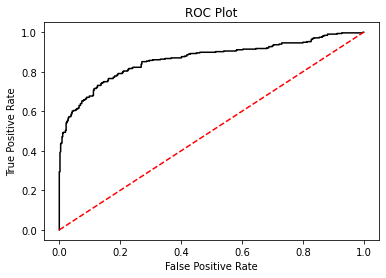

In [100]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, roc_curve
pred = rnn_model.predict(x_val)
fpr, tpr, th = roc_curve(y_val, pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
print("F1 Score RNN {}".format(f1_score(y_pred=pred >= 0.5, y_true=y_val)))

The F1 score is an important measure of the degree to which positives are correctly classified and detected. This is an ok score, but it could certainly be better. 

In [53]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
429/429 [==============================] - 116s 227ms/step - loss: 0.7135 - accuracy: 0.6519
Epoch 2/6
429/429 [==============================] - 99s 230ms/step - loss: 0.4345 - accuracy: 0.8100
Epoch 3/6
429/429 [==============================] - 99s 231ms/step - loss: 0.5007 - accuracy: 0.7530
Epoch 4/6
429/429 [==============================] - 99s 230ms/step - loss: 1.3180 - accuracy: 0.5243
Epoch 5/6
429/429 [==============================] - 1s 2ms/step - loss: 6.9080 - accuracy: 0.6719


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


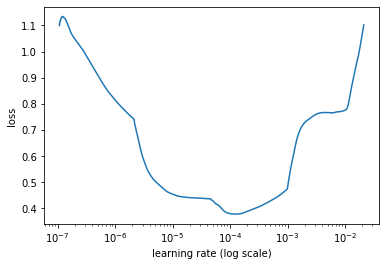

In [54]:
learner.lr_plot()

To determine what the best learning rate hyperameter should be, the BERT model was trained with learning rates of various magnitudes for 1 epoc each. It was determined that training with a learning rate of about 1e-4 yields the best results.

In [55]:
history=learner.autofit(
    1e-4,
    3,
    early_stopping=True,
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/3
429/429 [==============================] - 124s 247ms/step - loss: 0.4461 - accuracy: 0.8098 - val_loss: 0.4023 - val_accuracy: 0.8281
Epoch 2/3
429/429 [==============================] - 103s 240ms/step - loss: 0.3359 - accuracy: 0.8692 - val_loss: 0.3910 - val_accuracy: 0.8386
Epoch 3/3
429/429 [==============================] - 103s 240ms/step - loss: 0.2405 - accuracy: 0.9146 - val_loss: 0.4520 - val_accuracy: 0.8215
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [56]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [57]:
validation = learner.validate(val_data=valid, print_report=True)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       421
           1       0.83      0.81      0.82       341

    accuracy                           0.84       762
   macro avg       0.84      0.84      0.84       762
weighted avg       0.84      0.84      0.84       762



The BERT model has a substantially higher F1 score of 0.82. I hypothesize that the reason this model performs better than the custom RNN model is because it considers more features such as n_grams. In addition, this BERT model was pre-trained on a huge corpus of text prior to this study. In other words, it had a head start that allowed it to outperform less experienced models.

In [37]:
#predictor.save("drive/MyDrive/Bert")

### Model Interpretation

It can be difficult to interpret neural network models. Thankfully, the ktrain predictor class has an explain method that can show what words in a text contribute to the prediction probabiliy. Green words contribute to the model prediction and red words detract from it.

In [ ]:
#need this in order for explain to work
!pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip

In [72]:
disasters = list(val[val['target'] == 1]['text'])
predictor.explain(disasters[15])

It is interesting that "mhtw4fnet" had a role in determining the label of the tweet. Inclusion of news websites must be an indicator of disaster.  

In [73]:
predictor.explain(disasters[34])

Bad things must happen frequently at airports.

In [76]:
predictor.explain(disasters[40])

Lets observe what words and phrases are not indicative of a disaster tweet.

In [77]:
all_fine = list(val[val['target'] == 0]['text'])
predictor.explain(all_fine[15])

Hollywood movies commonly portray disasters and are often disasters in their own right. However, tweets about them aren't cause for concern. It is interesting that minor words like "about" and "the" contributed to correctly labeling this tweet as "not disaster".

It is unsual the words "in chile" (in red) are indicative of a disaster tweet. It appears that location names are more common in disaster tweets. It is impressive that this was correctly classified despite the abundance of disaster keywords.

In [78]:
predictor.explain(all_fine[5])

In [79]:
predictor.explain(all_fine[22])

Lets test the model by feeding it custom written tweets.

In [85]:
predictor.explain("My hair is a disaster today!!!")

It looks like the model correctly identified this hypothetical tweet as not being a disaster tweet.

In [83]:
predictor.explain("Northern California is the bomb!")

However, this tweet was incorrectly classified as a disaster tweet. It seems like the model is biased against location names. 

In [86]:
predictor.explain("Help! There are zombies on the street eating people's brains!!")

Thankfully, the model correctly listed this zombie apocalypse tweet as a disaster.

## Conclusion

It was determined that a model with a BERT architecture is a good disaster tweet detector, achieving an F1 score of 0.82 after training with a learning rate determined by hyperparameter tuning. It also seems that a large number of features and the use of n_grams had a positive contribution in the performance of the model. I suspect that the limited number of features from the GloVe imbedding was why the custom RNN model did not perform as well.

Using RNN interpretation techniques, the BERT model appears to distinguish between tweets based on word context, for the most part. One problem, however, is that the model places too much emphasis on words associated with place names, which the model is biased against. Fixing this problem may be a topic of future work. It may also be worth investigating other pre-trained architectures for use in this problem.

In [38]:
sample_submission = pd.read_csv("drive/MyDrive/nlp-getting-started/sample_submission.csv")

In [39]:
test_df = pd.read_csv("drive/MyDrive/nlp-getting-started/test.csv")

In [40]:
pred = predictor.predict(list(test_df['text']))

In [ ]:
predictions = [1 if item else 0 for item in (np.array(pred) == 'target')]
predictions

In [42]:
sample_submission["target"] = predictions

In [43]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [44]:
sample_submission.to_csv("submission.csv", index=False)